In [1]:
import os
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from textvec import vectorizers
from sklearn.datasets import fetch_20newsgroups
import itertools
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
RS = 13

In [2]:
def get_multiclass_20news_data():
    newsgroups_train = fetch_20newsgroups(subset='train')
    newsgroups_test = fetch_20newsgroups(subset='test')
    train_data = pd.DataFrame({'text': newsgroups_train.data, 'y': newsgroups_train.target})
    test_data = pd.DataFrame({'text': newsgroups_test.data, 'y': newsgroups_test.target})
    return train_data, test_data

In [3]:
def airline_multiclass_sentiment_data():
    df = pd.read_csv('./data/airline-sentiment/Airline-Sentiment-2-w-AA.csv',encoding = "ISO-8859-1")
    df.loc[df.airline_sentiment == 'negative','airline_sentiment'] = 0
    df.loc[df.airline_sentiment == 'positive','airline_sentiment'] = 1
    df.loc[df.airline_sentiment == 'neutral','airline_sentiment'] = 2
    X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, stratify=df.airline_sentiment, test_size=0.2, random_state=13)
    train_data = pd.DataFrame({'text': X_train, 'y': y_train})
    test_data = pd.DataFrame({'text': X_test, 'y': y_test})
    return train_data, test_data

In [4]:
news20_train_data, news20_test_data = get_multiclass_20news_data()

In [5]:
airmult_train_data, airmult_test_data = airline_multiclass_sentiment_data()

In [6]:
def count_score(baseVectorizer, freqVectorizer, model, train_data, test_data, with_prob=False, supervised=True):
    baseVectorizer.fit(train_data.text)
    if supervised:
        freqVectorizer.fit(baseVectorizer.transform(train_data.text), train_data.y)
    else:
        freqVectorizer.fit(baseVectorizer.transform(train_data.text))
    freq_train = freqVectorizer.transform(baseVectorizer.transform(train_data.text))
    freq_test = freqVectorizer.transform(baseVectorizer.transform(test_data.text))
    model.fit(freq_train, train_data.y)
    if with_prob:
        preds = model.predict_proba(freq_test)
    else:
        preds = model.predict(freq_test)
    return preds

In [7]:
def get_test_cases(train_data, test_data):
    return {
        'tf': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
                 "freqVectorizer":TfidfTransformer(sublinear_tf=True, use_idf=False),
                 "model":LogisticRegression(),
                 "train_data":train_data,
                 "test_data":test_data,
                 "with_prob":False,
                 "supervised":False
                },
        'tfidf': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
                 "freqVectorizer":TfidfTransformer(sublinear_tf=True),
                 "model":LogisticRegression(),
                 "train_data":train_data,
                 "test_data":test_data,
                 "with_prob":False,
                 "supervised":False
                },
        'tficf': {"baseVectorizer":CountVectorizer(ngram_range=(1,2)),
             "freqVectorizer":vectorizers.TfIcfVectorizer(sublinear_tf=True, norm=False),
             "model":LogisticRegression(),
             "train_data":train_data,
             "test_data":test_data,
             "with_prob":False,
             "supervised":True
            }
    }

In [8]:
def test_data(train_data, test_data, test_name = ''):
    cases = get_test_cases(train_data,test_data)
    for k, v in cases.items():
        cases[k].update({'preds': count_score(**v)})
        cases[k].update({'accuracy': accuracy_score(v['test_data'].y, v['preds'])})
    results = []
    for k, v in cases.items():
        results.append((k, v['accuracy'],v['preds']))
    results = sorted(results, key= lambda x:x[1], reverse=True)
    corrs = np.corrcoef(list(zip(*results))[2])
    accs = list(zip(*results))[1]
    labels = [f'{x}:{accs[i]:.4f}' for i, x in enumerate(list(zip(*results))[0])]
    fig, ax = plt.subplots(figsize=(10,10)) 
    ax = sns.heatmap(corrs, 
                     linewidth=0.5, 
                     annot=corrs, 
                     square=True, 
                     ax=ax, 
                     xticklabels=labels,
                     yticklabels=labels)
    ax.set_title(test_name)
    plt.show()

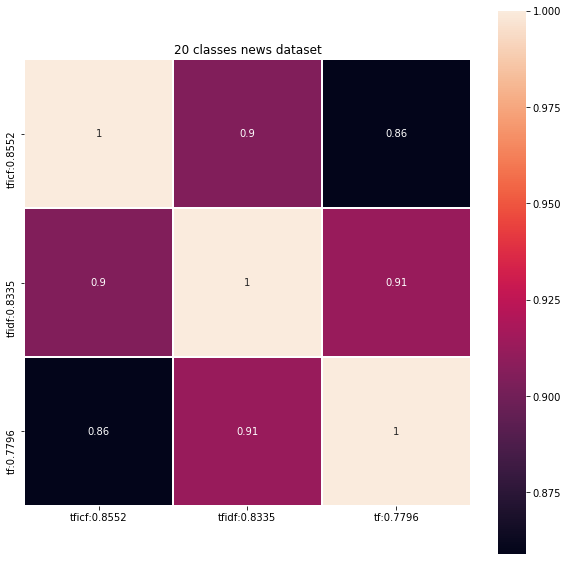

In [9]:
test_data(news20_train_data, news20_test_data, '20 classes news dataset')

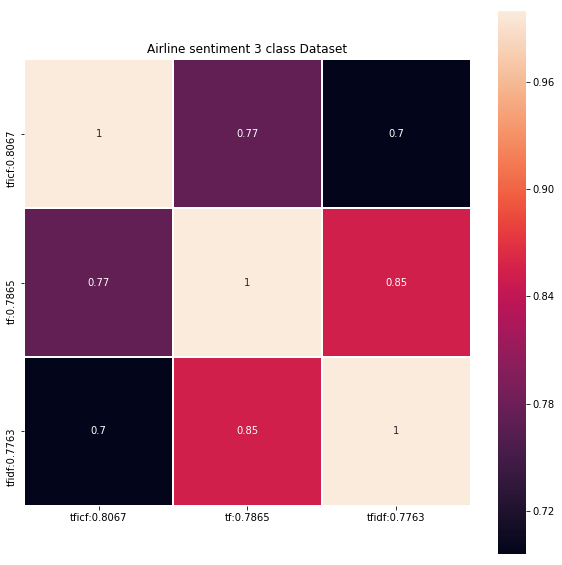

In [10]:
test_data(airmult_train_data, airmult_test_data, 'Airline sentiment 3 class Dataset')